## Predicción de tarifas de taxis

El objetivo es construir un modelo de aprendizaje que sea capaz de predecir la tarifa que cobra un taxi de acuerdo a un conjunto de datos de entrada, el cual está compuesto por un archivo CSV que contiene alrededor de 55 millones de registros de viajes en taxi.


Cada registro contiene la siguiente información:

1. ID: cadena que identifica de manera única a cada registro
2. pickup_datetime: timestamp indicando cuando el viaje a empezado
3. pickup_longitude: número real indicando la ubicación en longitud en donde el viaje empezó
4. pickup_latitude: número real indicando la ubicación en latitud en donde el viaje empezó
5. dropoff_longitude: número real indicando la ubicación en longitud en donde el viaje terminó
6. dropoff_latitude: número real indicando la ubicación en latitud en donde el viaje terminó
7. passenger_count: número entero indicando el número de pasajeros en el servicio de taxi
8. fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir.

### Importando la función para medir el tiempo

In [1]:
# medir tiempos
%load_ext autotime

time: 640 µs (started: 2021-06-14 10:02:35 -05:00)


En la siguiente imagen se puede visualizar que para cargar el archivo CSV que contiene toda la data, tarda aproximadamente 37 min, lo que implica una desventaja a la hora de entrenar un modelo. Por eso se opta por trabajar en paralelo, usando PySpark, que acelerará el proceso de la carga de todo el conjunto de datos.

![output](tiempo_secuencial.png)

### Importando el conjunto de datos usando Pyspark 

In [2]:
# Modulo para encontrar pyspark
import findspark
findspark.init("/usr/local/spark/spark-3.1.1-bin-hadoop2.7")    #para linux
#findspark.init()                                                 #para windows

time: 5.82 ms (started: 2021-06-14 10:02:38 -05:00)


In [3]:
# Importamos pyspark
from pyspark import SparkConf, SparkContext
# Variable de configuración depende de la PC
# conf -> renzo (0,4,16, 4)
conf = SparkConf().setMaster("local[*]") \
    .setAppName("ModeloML") \
    .set("spark.driver.maxResultSize","0") \
    .set("spark.executor.memory", "4g") \
    .set("spark.driver.memory", "16g") \
    .set("spark.cores.max", "4")
# Iniciamos un contexto spark (solo se ejecuta uno. Para ejecutar otra vez , reiniciar el kernel)
sc = SparkContext(conf = conf)
sc

<SparkContext master=local[*] appName=ModeloML>

time: 3.98 s (started: 2021-06-14 10:02:39 -05:00)


In [4]:
from pyspark.sql.types import StringType
from pyspark import SQLContext
# le pasamos el contexto anterior
sqlContext = SQLContext(sc)
dfspark = sqlContext.read.format('csv').option("header","true").option("inferSchema","true").load('train.csv')

time: 3min 46s (started: 2021-06-14 10:02:43 -05:00)


In [5]:
# Esquema de los datos
dfspark.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)

time: 24.7 ms (started: 2021-06-14 10:06:30 -05:00)


In [6]:
# Total de cantidad de datos
cant_total=dfspark.count()
cant_total

55423856

time: 14.5 s (started: 2021-06-14 10:06:30 -05:00)


In [7]:
# Tomando una muestra del 4% del total
dfspark_sample = dfspark.sample(fraction = 0.04, withReplacement = False, seed=0)

time: 10.7 ms (started: 2021-06-14 10:06:44 -05:00)


##### Apartir de aqui trabajamos con una muestra.

In [8]:
# Cantidad de datos para la muestra
cant_muestra=dfspark_sample.count()
cant_muestra

2219408

time: 16.7 s (started: 2021-06-14 10:06:44 -05:00)


### Limpieza de la data

Se procederá a eliminar la columna con la característica "key", debido a que contiene datos innecesarios para lograr el objetivo.

In [9]:
dfspark_sample = dfspark_sample.drop('key')

time: 9.79 ms (started: 2021-06-14 10:07:01 -05:00)


Eliminando Valores Nulos de la tabla

In [10]:
# fare_amount (costo de viaje) no nulos
dfspark_sample = dfspark_sample.filter("fare_amount is not NULL")
# passenger (número de pasajeros) no nulos
dfspark_sample = dfspark_sample.filter("passenger_count is not NULL")
# pickup_datetime (fecha y hora de incio de viaje) no nulos
dfspark_sample = dfspark_sample.filter("pickup_datetime is not NULL")
# pickup (longitud y latitud de inicio de viaje) no nulos
dfspark_sample = dfspark_sample.filter("pickup_longitude is not NULL")
dfspark_sample = dfspark_sample.filter("pickup_latitude is not NULL")
# dropoff (longitud y laitud de fin de viaje) no nulos
dfspark_sample = dfspark_sample.filter("dropoff_longitude is not NULL")
dfspark_sample = dfspark_sample.filter("dropoff_latitude is not NULL")

time: 606 ms (started: 2021-06-14 10:07:01 -05:00)


Eliminado valores nan y duplicados

In [11]:
# Tabla sin valores nan, sin duplicados
dfspark_sample=dfspark_sample.na.drop().dropDuplicates()

time: 238 ms (started: 2021-06-14 10:07:02 -05:00)


In [12]:
# Que el comjunto de datos persista en memoria, acelera algunos procesos.
dfspark_sample.persist()

DataFrame[fare_amount: double, pickup_datetime: string, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, passenger_count: int]

time: 377 ms (started: 2021-06-14 10:07:02 -05:00)


In [13]:
# Cantidad de datos sin nulos, ni nan, ni duplicados
nueva_cant_muestra=dfspark_sample.count()
print("Cantidad de filas eliminadas de la muestra: ",cant_muestra-nueva_cant_muestra)
print("Nueva cantidad de datos: ",nueva_cant_muestra)

Cantidad de filas eliminadas de la muestra:  18
Nueva cantidad de datos:  2219390
time: 1min 2s (started: 2021-06-14 10:07:02 -05:00)


### Estadísticas

In [14]:
import numpy as np
import pandas as pd

time: 2.77 s (started: 2021-06-14 10:08:05 -05:00)


In [15]:
# Casteamos a pandas
summary=dfspark_sample.describe(["pickup_longitude",
                                 "pickup_latitude",
                                 "dropoff_longitude",
                                 "dropoff_latitude",
                                 "passenger_count",
                                 "fare_amount"]).toPandas()

time: 1.97 s (started: 2021-06-14 10:08:08 -05:00)


In [16]:
summary

,summary,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,count,2219390,2219390,2219390,2219390,2219390,2219390
1,mean,-72.50355231460159,39.91779369363991,-72.50697030839864,39.91850726486102,1.6851959322156087,11.352503967306385
2,stddev,13.098889190132796,9.821243657749829,13.244549098861283,10.317917931047642,1.3377753769552685,42.449025079080954
3,min,-3366.527908,-3488.079513,-3366.527908,-3488.079513,0,-52.0
4,max,2497.117435,2964.163855,3211.57975,3333.304575,208,61550.86


time: 48.8 ms (started: 2021-06-14 10:08:10 -05:00)


In [17]:
# Agrupación por cantidad de pasajeros.
dfspark_sample.groupBy("passenger_count").count().show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|1535882|
|              6|  47132|
|              3|  97242|
|              5| 157254|
|              4|  47158|
|              7|      1|
|              2| 326983|
|              0|   7734|
|            208|      4|
+---------------+-------+

time: 2.31 s (started: 2021-06-14 10:08:10 -05:00)


### Observaciones :
1. Valores de passenger_count imposibles , como 34,49,51,129,208.
2. Precios demasiados elevados debido a la cantidad de pasajeros y negativo(imposible).
3. Cantidad de datos en la que el precio es menor a o igual a 0

In [18]:
# Mínimo y máximo para longitud del subconjunto de datos
long_min_i=dfspark_sample.agg({'pickup_longitude': 'min'}).show()
long_max_i=dfspark_sample.agg({'pickup_longitude': 'max'}).show()
long_min_f=dfspark_sample.agg({'dropoff_longitude': 'min'}).show()
long_max_f=dfspark_sample.agg({'dropoff_longitude': 'max'}).show()

# Mínimo y máximo para para latitud del subconjuntos de datos
lat_min_i=dfspark_sample.agg({'pickup_latitude': 'min'}).show()
lat_max_i=dfspark_sample.agg({'pickup_latitude': 'max'}).show()
lat_min_f=dfspark_sample.agg({'dropoff_latitude': 'min'}).show()
lat_max_f=dfspark_sample.agg({'dropoff_latitude': 'max'}).show()

+---------------------+
|min(pickup_longitude)|
+---------------------+
|         -3366.527908|
+---------------------+

+---------------------+
|max(pickup_longitude)|
+---------------------+
|          2497.117435|
+---------------------+

+----------------------+
|min(dropoff_longitude)|
+----------------------+
|          -3366.527908|
+----------------------+

+----------------------+
|max(dropoff_longitude)|
+----------------------+
|            3211.57975|
+----------------------+

+--------------------+
|min(pickup_latitude)|
+--------------------+
|        -3488.079513|
+--------------------+

+--------------------+
|max(pickup_latitude)|
+--------------------+
|         2964.163855|
+--------------------+

+---------------------+
|min(dropoff_latitude)|
+---------------------+
|         -3488.079513|
+---------------------+

+---------------------+
|max(dropoff_latitude)|
+---------------------+
|          3333.304575|
+---------------------+

time: 4.74 s (started: 2021-06-1

### Observaciones:
1. Valores para longitud imposibles, ya que longitud varía entre -90 y 90
2. Valores para latitud imposibles, ya que latitud varía entre -180 y 180

# Transformación de la data

In [19]:
# Seleccionar passenger_count de 0-9
dfspark_sample = dfspark_sample.filter("passenger_count < 10")
# Selecionar fare_amount mayor a 0
dfspark_sample = dfspark_sample.filter("fare_amount >= 0 and fare_amount <= 100")

time: 68.1 ms (started: 2021-06-14 10:08:17 -05:00)


In [20]:
dfspark_sample.groupBy("passenger_count").count().show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|1535151|
|              6|  47119|
|              3|  97212|
|              5| 157231|
|              4|  47132|
|              7|      1|
|              2| 326869|
|              0|   7734|
+---------------+-------+

time: 2.39 s (started: 2021-06-14 10:08:17 -05:00)


In [21]:
# Filtrando valores grandes para longitud, de tal manera que solo se considerará valores correctos.
dfspark_sample = dfspark_sample.filter("pickup_longitude < 180 and pickup_longitude > -180" )
dfspark_sample = dfspark_sample.filter("dropoff_longitude < 180 and dropoff_longitude > -180")
dfspark_sample = dfspark_sample.filter("pickup_latitude < 90 and pickup_latitude > -90" )
dfspark_sample = dfspark_sample.filter("dropoff_latitude < 90 and dropoff_latitude > -90")

time: 57.3 ms (started: 2021-06-14 10:08:19 -05:00)


In [22]:
estadisticas=dfspark_sample.describe(["pickup_longitude",
                                 "pickup_latitude",
                                 "dropoff_longitude",
                                 "dropoff_latitude",
                                  "fare_amount"]).toPandas()

time: 2.42 s (started: 2021-06-14 10:08:19 -05:00)


In [23]:
estadisticas

,summary,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
0,count,2218324,2218324,2218324,2218324,2218324
1,mean,-72.49792642807238,39.9178324326265,-72.50456776388887,39.92090591335847,11.277273396492163
2,stddev,10.456633559991248,6.108952929695163,10.431325659855101,6.10028741263642,9.39446820001931
3,min,-121.91499328613281,-74.017222,-121.9151840209961,-74.177303,0.0
4,max,40.840962,74.007413,73.93996,74.95,100.0


time: 11.9 ms (started: 2021-06-14 10:08:22 -05:00)


In [24]:
# Agregamos columnas de diferencias.
from pyspark.sql.functions import abs
dfspark_sample = dfspark_sample.withColumn("dif_latitude",
                                           abs(dfspark_sample['dropoff_latitude']-dfspark_sample['pickup_latitude']))
dfspark_sample = dfspark_sample.withColumn("dif_longitude",
                                           abs(dfspark_sample['dropoff_longitude']-dfspark_sample['pickup_longitude']))

time: 287 ms (started: 2021-06-14 10:08:22 -05:00)


In [25]:
# Creamos la función para hallar la distancia entre dos puntos geográficos
import math
from pyspark.sql.functions import udf, array, col
from pyspark.sql.types import FloatType

def haversine(x):
    lat1=x[0]
    lon1=x[1]
    lat2=x[2]
    lon2=x[3]
    
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia

distancia_udf = udf(lambda z: haversine(z), FloatType())
#spark.udf.register('distancia_udf', distancia_udf)
dfspark_sample = dfspark_sample.withColumn('distancia', distancia_udf(array('pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')))                             

time: 115 ms (started: 2021-06-14 10:08:22 -05:00)


In [26]:
dfspark_sample.select(col('distancia')).show()

+----------+
| distancia|
+----------+
| 1.8683056|
| 1.8191968|
|  1.145462|
| 1.0793539|
| 1.1367035|
|  2.424119|
|  3.829884|
| 1.0900514|
| 5.5276585|
|  3.122764|
| 2.3627946|
| 5.3667502|
| 1.3431213|
|  9.317738|
|  5.013023|
| 4.6022677|
| 1.1546545|
| 20.964258|
| 0.8852747|
|0.17227533|
+----------+
only showing top 20 rows

time: 985 ms (started: 2021-06-14 10:08:22 -05:00)


In [27]:
# Creamos dos columnas día de la semana y hora del viaje.
# funciones que me ayudarán en la transformación.
from datetime import datetime, date, time, timedelta
import calendar
def dia(dia):
    if dia == 1:
        return 'lunes'
    if dia == 2:
        return 'martes'
    if dia == 3:
        return 'miércoles'
    if dia == 4:
        return 'jueves'
    if dia == 5:
        return 'viernes'
    if dia == 6:
        return 'sábado'
    if dia == 7:
        return 'domingo'
    if dia < 1 or dia > 7:
        return 

from pyspark.sql import Row

def dia_semana(row):
    fecha , hora , utc = row.split(" ")
    formato_fecha = "%Y-%m-%d"
    dia_semana = datetime.isoweekday(datetime.strptime(fecha,formato_fecha))
    return dia_semana

def mes(row):
    fecha , hora , utc = row.split(" ")
    formato_fecha = "%Y-%m-%d"
    mes = datetime.strptime(fecha,formato_fecha).month
    return mes

def anio(row):
    fecha , hora , utc = row.split(" ")
    formato_fecha = "%Y-%m-%d"
    anio = datetime.strptime(fecha,formato_fecha).year
    return anio

def hora(row):
    fecha , hora , utc = row.split(" ")
    formato_hora = "%H:%M:%S"
    hora = datetime.strptime(hora,formato_hora).hour
    return hora
    
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
# Convirtiendo las funciones en funciones UDF
udf_dia_semana= udf( lambda z : dia_semana(z), IntegerType())
udf_mes= udf( lambda z : mes(z), IntegerType())
udf_anio= udf( lambda z : anio(z), IntegerType())
udf_hora= udf( lambda z : hora(z), IntegerType())

time: 3.49 ms (started: 2021-06-14 10:08:23 -05:00)


In [28]:
from pyspark.sql.functions import col
dfspark_sample = dfspark_sample.withColumn('dia_semana', 
                                           udf_dia_semana(dfspark_sample['pickup_datetime'] )  )
dfspark_sample = dfspark_sample.withColumn('hora', 
                                           udf_hora(dfspark_sample['pickup_datetime'] )  )
dfspark_sample = dfspark_sample.withColumn('mes', 
                                           udf_mes(dfspark_sample['pickup_datetime'] )  )
dfspark_sample = dfspark_sample.withColumn('anio', 
                                           udf_anio(dfspark_sample['pickup_datetime'] )  )

time: 188 ms (started: 2021-06-14 10:08:23 -05:00)


In [29]:
# Castear dia de la semana y hora
dfspark_sample = dfspark_sample.withColumn("dia_semana",
                                           dfspark_sample["dia_semana"].cast("Integer"))
dfspark_sample = dfspark_sample.withColumn("hora",
                                           dfspark_sample["hora"].cast("Integer"))

time: 127 ms (started: 2021-06-14 10:08:23 -05:00)


In [30]:
dfspark_sample.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- dif_latitude: double (nullable = true)
 |-- dif_longitude: double (nullable = true)
 |-- distancia: float (nullable = true)
 |-- dia_semana: integer (nullable = true)
 |-- hora: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- anio: integer (nullable = true)

time: 105 ms (started: 2021-06-14 10:08:24 -05:00)


##### Guardando el conjunto de datos  en un carpeta output 

In [31]:
import os
path="file:"+os.getcwd()+"/Output"                  ## para linux
#path=os.getcwd()+"/Output"                             ## para windows   
dfspark_sample.write.format("csv").option("header", "true").save(path)

time: 49.9 s (started: 2021-06-14 10:08:24 -05:00)


### Estadística de las nuevas variables

In [32]:
clean_summary=dfspark_sample.describe().toPandas()

time: 1min 3s (started: 2021-06-14 10:09:14 -05:00)


In [33]:
columnas = ["summary",
            "pickup_longitude",
            "pickup_latitude",
            "dropoff_longitude",
            "dropoff_latitude",
            "passenger_count",
            "fare_amount",
            "dif_latitude",
            "dif_longitude",
            "dia_semana",
            "mes",
            "anio",
            "hora",
            "distancia"]
clean_summary[columnas]

,summary,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,dif_latitude,dif_longitude,dia_semana,mes,anio,hora,distancia
0,count,2218324,2218324,2218324,2218324,2218324,2218324,2218324,2218324,2218324,2218324,2218324,2218324,2218324
1,mean,-72.49792642807238,39.9178324326265,-72.50456776388887,39.92090591335847,1.6849292528954292,11.277273396492163,0.09176222668703253,0.16077182305195567,4.042986957721235,6.269624725693812,2011.7396935704612,13.512985028336708,19.27087632112479
2,stddev,10.456633559991248,6.108952929695163,10.431325659855101,6.10028741263642,1.3088809439997708,9.39446820001931,1.6932595458984998,3.1881265967253563,1.9490554912068403,3.434570455790501,1.8603202961678926,6.517796106831022,364.591103794953
3,min,-121.91499328613281,-74.017222,-121.9151840209961,-74.177303,0,0.0,0.0,0.0,1,1,2009,0,0.0
4,max,40.840962,74.007413,73.93996,74.95,7,100.0,73.961092,89.483332,7,12,2015,23,9952.922


time: 147 ms (started: 2021-06-14 10:10:17 -05:00)


### Correlación de los atributos

In [34]:
col_old=["pickup_longitude",
         "pickup_latitude",
         "dropoff_longitude",
         "dropoff_latitude",
         "passenger_count"]
col_new=["dif_latitude",
         "dif_longitude",
         "dia_semana",
         "mes",
         "anio",
         "hora",
         "distancia"]
col_pred = ["fare_amount"]

time: 67.7 ms (started: 2021-06-14 10:10:17 -05:00)


In [35]:
# Transformación en un vector
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
inputCols = col_old+col_new+col_pred
assembler = VectorAssembler( inputCols=inputCols, outputCol="col_corr")
dfspark_corr = assembler.transform(dfspark_sample)

time: 2.07 s (started: 2021-06-14 10:10:17 -05:00)


In [36]:
dfspark_corr=dfspark_corr.select('col_corr')

time: 7.85 ms (started: 2021-06-14 10:10:19 -05:00)


In [37]:
# estudiar la correlación
from pyspark.ml.stat import Correlation

dfspark_corr= Correlation.corr(dfspark_corr, 'col_corr','pearson')

time: 1min 37s (started: 2021-06-14 10:10:19 -05:00)


In [38]:
from pyspark.ml.linalg import DenseMatrix, Vectors
#type(dfspark_cor.collect()[0][0]) # denseMatrix
# Pasamos la matrix como un array.
array_corr=dfspark_corr.collect()[0][0].toArray()

time: 32.1 ms (started: 2021-06-14 10:11:56 -05:00)


In [39]:
pdf_corr= pd.DataFrame(array_corr, columns=inputCols, index=inputCols)
mask = ~(pdf_corr>-0.3) | ~(pdf_corr<0.3)
round(pdf_corr,10).style.background_gradient()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dif_latitude,dif_longitude,dia_semana,mes,anio,hora,distancia,fare_amount
pickup_longitude,1.000000,-0.979288,0.953293,-0.940479,0.000231,0.145015,0.154224,0.002339,-0.001889,0.006716,-0.002218,0.154292,0.007719
pickup_latitude,-0.979288,1.000000,-0.941124,0.961420,-0.001127,-0.136226,-0.126460,-0.003786,0.003154,-0.009091,0.002185,-0.132377,-0.007455
dropoff_longitude,0.953293,-0.941124,1.000000,-0.980091,0.000251,0.132665,0.137844,0.002705,-0.001392,0.008110,-0.002621,0.138994,0.008398
dropoff_latitude,-0.940479,0.961420,-0.980091,1.000000,-0.001557,-0.125677,-0.115299,-0.004012,0.002815,-0.010421,0.002309,-0.121379,-0.008429
passenger_count,0.000231,-0.001127,0.000251,-0.001557,1.000000,-0.002477,-0.001283,0.035582,0.005101,0.003857,0.017158,-0.001613,0.015564
dif_latitude,0.145015,-0.136226,0.132665,-0.125677,-0.002477,1.000000,0.922864,-0.001826,-0.000067,0.025281,-0.000769,0.966636,0.028219
dif_longitude,0.154224,-0.126460,0.137844,-0.115299,-0.001283,0.922864,1.000000,-0.002606,-0.000453,0.024555,-0.000862,0.989278,0.027300
dia_semana,0.002339,-0.003786,0.002705,-0.004012,0.035582,-0.001826,-0.002606,1.000000,-0.008007,0.006402,-0.087573,-0.002403,0.003353
mes,-0.001889,0.003154,-0.001392,0.002815,0.005101,-0.000067,-0.000453,-0.008007,1.000000,-0.117962,-0.004674,-0.000395,0.025254
anio,0.006716,-0.009091,0.008110,-0.010421,0.003857,0.025281,0.024555,0.006402,-0.117962,1.000000,-0.000412,0.025075,0.117271


time: 2.23 s (started: 2021-06-14 10:11:56 -05:00)


### Observación:
La variable a predecir fare_amount tiene muy baja correlación con las demás variables. Es decir podemos obtener información relevante de cada atributo para poder predecir el fare_amount.

### Visualización de la data.

In [40]:
# Pasamos toda la data a Pandas
pandasData = dfspark_sample.toPandas()

time: 57.1 s (started: 2021-06-14 10:11:58 -05:00)


In [41]:
#Mostrando la data
display(pandasData.groupby("anio").count())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dif_latitude,dif_longitude,distancia,dia_semana,hora,mes
anio,,,,,,,,,,,,,
2009,341879,341879,341879,341879,341879,341879,341879,341879,341879,341879,341879,341879,341879
2010,334493,334493,334493,334493,334493,334493,334493,334493,334493,334493,334493,334493,334493
2011,353988,353988,353988,353988,353988,353988,353988,353988,353988,353988,353988,353988,353988
2012,355998,355998,355998,355998,355998,355998,355998,355998,355998,355998,355998,355998,355998
2013,347278,347278,347278,347278,347278,347278,347278,347278,347278,347278,347278,347278,347278
2014,330175,330175,330175,330175,330175,330175,330175,330175,330175,330175,330175,330175,330175
2015,154513,154513,154513,154513,154513,154513,154513,154513,154513,154513,154513,154513,154513


time: 440 ms (started: 2021-06-14 10:12:55 -05:00)


**Muestra como varia la cantidad de pasajeros por año por cada mes**

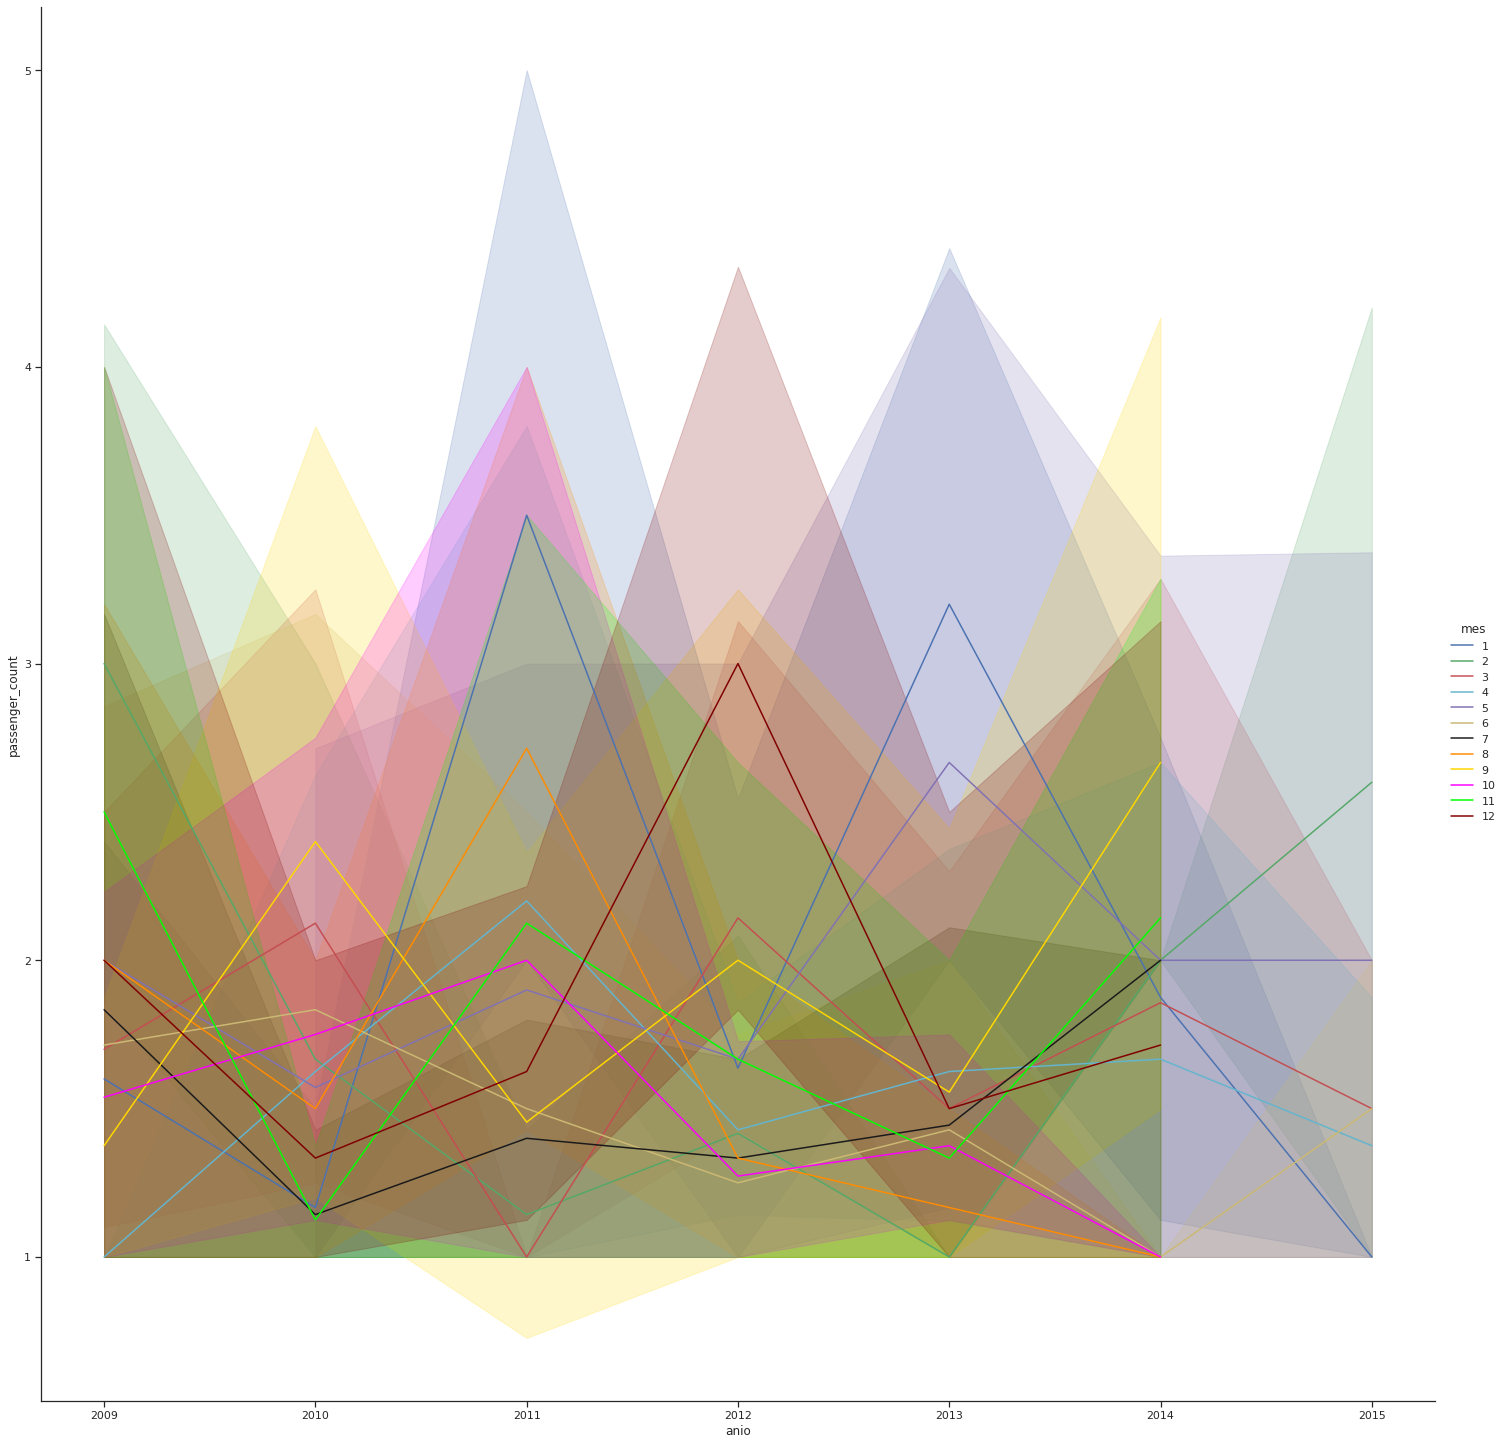

time: 5.13 s (started: 2021-06-14 10:12:56 -05:00)


In [42]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="ticks" , color_codes = True)
var = ["dia_semana"]
# 1 inches = 96px
sns.relplot(x="anio", 
            y="passenger_count", 
            data=pandasData[0:500], 
            kind="line", 
            hue="mes", 
            palette=["b", "g","r","c","m","y","k","darkorange","gold","magenta","lime","maroon"],
           height=20)

**Muestra como los pasajeros se distribuyen a traves de las horas, por ejemplo podemos apreciar que la hora en que viajan menos pasajeros es a las 5am, en contraparte la hora punta viene a ser las 7 pm**

Text(0.5, 0, 'Suma de los pasajeron según la hora')

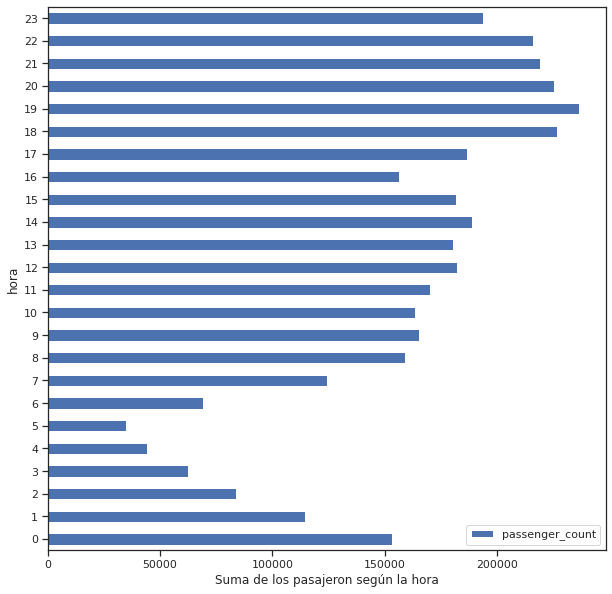

time: 543 ms (started: 2021-06-14 10:13:01 -05:00)


In [43]:
import matplotlib.pyplot as plt

pandasData.groupby('hora')['passenger_count'].sum().plot(kind='barh',legend='Reverse',figsize=(10,10))
plt.xlabel('Suma de los pasajeron según la hora')

**El siguiente grafico muestra en porcentaje como se distribuye la cantidad de pasajeros segun los dias de la semana**

Text(0, 0.5, '')

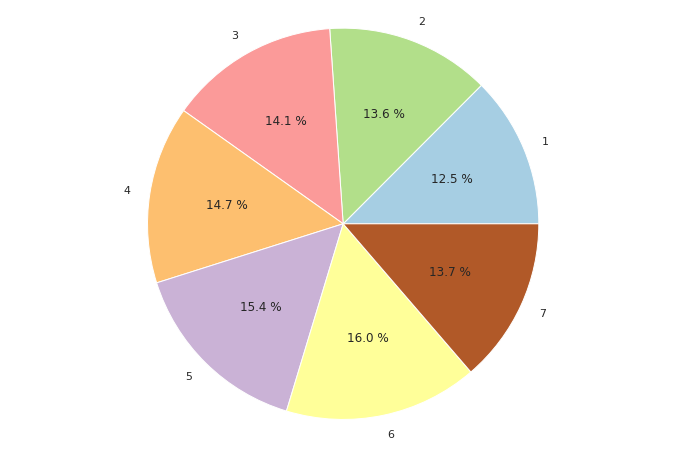

time: 346 ms (started: 2021-06-14 10:13:01 -05:00)


In [44]:
pandasData.passenger_count.groupby(pandasData.dia_semana).sum().plot(kind='pie',cmap='Paired',figsize=(12,8),autopct="%0.1f %%")
plt.axis('equal')
plt.ylabel('')

**En este diagrama de densidad muestra la distribucion del costo del taxi**

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

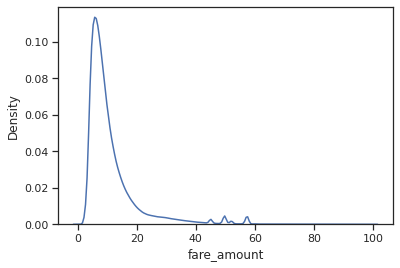

time: 6.94 s (started: 2021-06-14 10:13:02 -05:00)


In [45]:
from seaborn import kdeplot

kdeplot(pandasData.fare_amount)

**En la siguiente gráfica se muestra la relación entre las características hora, dia_semana y passenger_count según los meses**

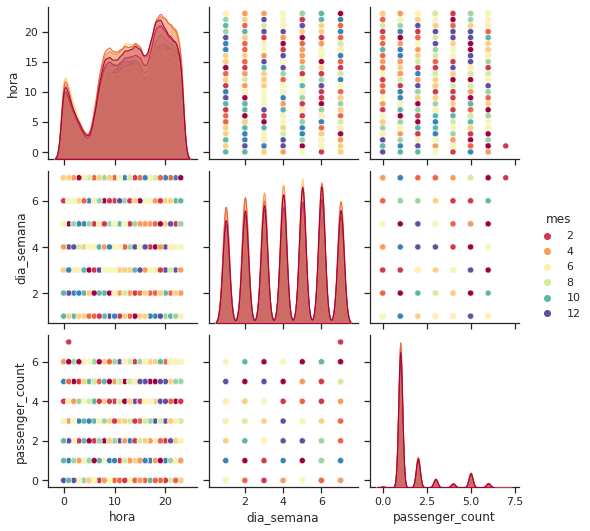

time: 10min 52s (started: 2021-06-14 10:13:09 -05:00)


In [46]:
#Dispersion de las características
caracteristicas=pandasData[['mes','hora','dia_semana','passenger_count']]
sns.set(style="ticks", color_codes=True)
g= sns.pairplot(caracteristicas,hue='mes',palette='Spectral')

**Gráfica que muestra la relación entre las características passenger_count y la hora del viaje, además se muestra una linea de regresión con la tendencia entre ambas características según los días de la semana, por ejemplo para los domingos se visualiza un declive, sin embargo, en los demás días hay una tendencia al incremento de pasajeros.**

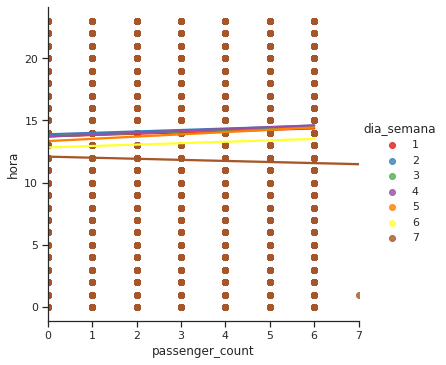

time: 4min 46s (started: 2021-06-14 10:24:01 -05:00)


In [47]:
# Relación entre dos caracteristicas vista como tendencia lineal
g=sns.lmplot(x='passenger_count',y='hora',hue='dia_semana',data=caracteristicas,palette='Set1')

**En la gráfica se muestran como va cambiando la tendencia de la distancia en carreras hechas por el taxi en un rango entre 5 y 30, se puede visualizar la preferencia en tomar carreras cortas.**

In [48]:
sc.stopp()

time: 1.04 s (started: 2021-06-14 10:28:48 -05:00)
